<a href="https://colab.research.google.com/github/Jtwulf/kthr_lab/blob/main/main2022-09-05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!python --version

Python 3.10.12


In [7]:
# !apt install ffmpeg
!pip install demucs
!pip install mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.8/418.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 900.6 kB/s eta 0:00:00


In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import io
import os
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO
from google.colab import files
import mido
import pprint
from abc import ABC

In [9]:
class Visualizer(ABC):
    def plot(self):
        pass

In [6]:
class AudioSeparator:
    def __init__(self, in_path, out_path, model="mdx_q", extensions=["mp3", "wav", "ogg", "flac"], two_stems=None, mp3=True, mp3_rate=320, float32=False, int24=False):
        self.in_path = in_path
        self.out_path = out_path
        self.model = model
        self.extensions = extensions
        self.two_stems = two_stems
        self.mp3 = mp3
        self.mp3_rate = mp3_rate
        self.float32 = float32
        self.int24 = int24
        self.stems = ['bass.mp3', 'drums.mp3', 'vocals.mp3', 'other.mp3']

    def separate(self, inp=None, outp=None):
        inp = inp or self.in_path
        outp = outp or self.out_path

        cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", self.model]
        if self.mp3:
            cmd += ["--mp3", f"--mp3-bitrate={self.mp3_rate}"]
        if self.float32:
            cmd += ["--float32"]
        if self.int24:
            cmd += ["--int24"]
        if self.two_stems is not None:
            cmd += [f"--two-stems={self.two_stems}"]

        files = [str(f) for f in self._find_files(inp)]
        if not files:
            print(f"No valid audio files in {self.in_path}")
            return

        print("Going to separate the files:")
        print('\n'.join(files))
        print("With command: ", " ".join(cmd))
        p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
        self._copy_process_streams(p)
        p.wait()
        if p.returncode != 0:
            print("Command failed, something went wrong.")

    def _is_separated(self, outp):
        return all(os.path.exists(Path(outp, stem)) for stem in self.stems)

    def _find_files(self, in_path):
        out = []
        in_path = Path(in_path)
        if in_path.is_dir():
            for file in in_path.iterdir():
                if file.suffix.lower().lstrip(".") in self.extensions:
                    out.append(file)
        else:
            if in_path.suffix.lower().lstrip(".") in self.extensions:
                out.append(in_path)
        return out


    def _copy_process_streams(self, process: sp.Popen):
        def _raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
            assert stream is not None
            if isinstance(stream, io.BufferedIOBase):
                stream = stream.raw
            return stream

        p_stdout, p_stderr = _raw(process.stdout), _raw(process.stderr)
        stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
            p_stdout.fileno(): (p_stdout, sys.stdout),
            p_stderr.fileno(): (p_stderr, sys.stderr),
        }
        fds = list(stream_by_fd.keys())

        while fds:
            ready, _, _ = select.select(fds, [], [])
            for fd in ready:
                p_stream, std = stream_by_fd[fd]
                raw_buf = p_stream.read(2 ** 16)
                if not raw_buf:
                    fds.remove(fd)
                    continue
                buf = raw_buf.decode()
                std.write(buf)
                std.flush()

    # def from_upload(self):
    #     out_path = Path('separated')
    #     in_path = Path('tmp_in')

    #     if in_path.exists():
    #         rmtree(in_path)
    #     in_path.mkdir()

    #     if out_path.exists():
    #         rmtree(out_path)
    #     out_path.mkdir()

    #     uploaded = files.upload()
    #     for name, content in uploaded.items():
    #         (in_path / name).write_bytes(content)
    #     self.separate(in_path, out_path)

In [7]:
class RMSVisualizer(Visualizer):
    def __init__(self, in_path, demucs_in_path, out_path, sr=44100, frame_length=65000, hop_length=16250, n_ignore=10):
        self.in_path = in_path
        self.sr = sr
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.n_ignore = n_ignore
        self.demucs_in_path = demucs_in_path

    def plot(self):
        rms, times = self._compute_rms(self.in_path)

        rms_data = []
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/bass.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/drums.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/other.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/vocals.mp3")[0])

        labels = ["bass", "drums", "vocals", "other"]

        self._plot_rms(times, rms_data, labels)

    def _compute_rms(self, file):
        y, _ = librosa.load(file, sr=self.sr, mono=True)
        rms = librosa.feature.rms(y=y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        rms /= np.max(rms)
        times = np.floor(librosa.times_like(rms, hop_length=self.hop_length, sr=self.sr))

        return rms, times

    def _compute_splited_rms(self, file, s_file):
        s_y, s_sr = librosa.load(s_file, sr=44100, mono=True)
        y, _ = librosa.load(file, sr=44100, mono=True)
        s_rms = librosa.feature.rms(y=s_y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        rms = librosa.feature.rms(y=y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        s_rms /= np.max(rms)
        times = np.floor(librosa.times_like(s_rms, hop_length=self.hop_length, sr=s_sr))

        return s_rms, times

    def _plot_rms(self, times, rms_data, labels):
        plt.figure(figsize=(15, 5))
        plt.ylabel("RMS")
        plt.xlabel("time")

        colors = ["blue", "magenta", "yellow", "green"]
        for rms, label, color in zip(rms_data, labels, colors):
            plt.plot(rms, label=label, color=color ,lw=2, alpha=1)

        plt.legend()
        plt.show()

    def _plot_rms_with_color(self, times, rms_data, labels):
        plt.figure(figsize=(15, 5))
        plt.ylabel("RMS")
        plt.xlabel("time")

        red_count = 0
        for i in range(len(times)):
            if rms_data[0][i] > 0.7:
                red_count += 1
                plt.vlines(i, 0, 1, color="red", alpha=0.4)
            else:
                plt.vlines(i, 0, 1, color="green", alpha=0.4)
                if red_count == 0:
                    plt.vlines(i, 0, 1, color="yellow", alpha=0.4)

        red_count_2 = 0
        for i in range(len(times)):
            if red_count == red_count_2:
                plt.vlines(i, 0, 1, color="blue", alpha=0.4)
            if rms_data[0][i] > 0.7:
                red_count_2 += 1

        colors = ["blue", "magenta", "yellow", "green"]
        for rms, label, color in zip(rms_data, labels, colors):
            plt.plot(rms, label=label, color=color ,lw=2, alpha=1)

        plt.legend()
        plt.show()

In [70]:
class DrumMidiVisualizer(Visualizer):
    def __init__(self, in_path, out_path):
        self.in_path = in_path
        self.out_path = out_path
        self.drum_mapping = {
            35: 'Acoustic Bass Drum',
            36: 'Bass Drum 1',
            37: 'Side Stick',
            38: 'Acoustic Snare',
            39: 'Hand Clap',
            40: 'Electric Snare',
            41: 'Low Floor Tom',
            42: 'Closed Hi-Hat',
            43: 'High Floor Tom',
            44: 'Pedal Hi-Hat',
            45: 'Low Tom',
            46: 'Open Hi-Hat',
            47: 'Low-Mid Tom',
            48: 'Hi-Mid Tom',
            49: 'Crash Cymbal 1',
            50: 'High Tom',
            51: 'Ride Cymbal 1',
            52: 'Chinese Cymbal',
            53: 'Ride Bell',
            54: 'Tambourine',
            55: 'Splash Cymbal',
            56: 'Cowbell',
            57: 'Crash Cymbal 2',
            58: 'Vibraslap',
            59: 'Ride Cymbal 2',
            60: 'Hi Bongo',
            61: 'Low Bongo',
            62: 'Mute Hi Conga',
            63: 'Open Hi Conga',
            64: 'Low Conga',
            65: 'High Timbale',
            66: 'Low Timbale',
            67: 'High Agogo',
            68: 'Low Agogo',
            69: 'Cabasa',
            70: 'Maracas',
            71: 'Short Whistle',
            72: 'Long Whistle',
            73: 'Short Guiro',
            74: 'Long Guiro',
            75: 'Claves',
            76: 'Hi Wood Block',
            77: 'Low Wood Block',
            78: 'Mute Cuica',
            79: 'Open Cuica',
            80: 'Mute Triangle',
            81: 'Open Triangle'
            }

    def plot(self, start_time=None, end_time=None):
        mid = mido.MidiFile(self.in_path)
        events = self._extract_events(mid)
        filtered_events = self._filter_events_by_time(events, start_time, end_time)
        self._plot_events(filtered_events)

    def _extract_events(self, mid):
        events = {}
        drum_counter = 0
        time = 0
        tempo = mido.bpm2tempo(120)

        for track in mid.tracks:
            for msg in track:
                time += mido.tick2second(msg.time, mid.ticks_per_beat, tempo)
                new_tempo = self._extract_tempo(msg)
                if new_tempo is not None:
                    tempo = new_tempo
                elif self._is_drum_part(msg):
                    if msg.note not in events:
                        events[msg.note] = {'name': self.drum_mapping[msg.note], 'id': drum_counter, 'times': []}
                        drum_counter += 1
                    events[msg.note]['times'].append(time)
        return events

    def _filter_events_by_time(self, events, start_time=None, end_time=None):
        if start_time is None and end_time is None:
            return events

        filtered_events = {}
        for drum_note, event in events.items():
            filtered_times = []
            for t in event['times']:
                if (start_time is None or start_time <= t) and (end_time is None or t <= end_time):
                    filtered_times.append(t)
            if filtered_times:
                filtered_events[drum_note] = {'name': event['name'], 'id': event['id'], 'times': filtered_times}
        pprint.pprint(filtered_events, depth=2)
        return filtered_events

    def _plot_events(self, events):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title('Drum elements over time')
        plt.grid(True)
        plt.show()

    def _extract_tempo(self, message):
        if message.type == 'set_tempo':
            return message.tempo
        return None

    def _is_drum_part(self, message):
        return message.type == 'note_on' and message.note in self.drum_mapping

    #################

    def _calculate_similarity(self, times):
        intervals = np.diff(times)
        avg_interval = np.mean(intervals)
        std_deviation = np.std(intervals)
        return avg_interval, std_deviation

    def _detect_pattern_changes(self, events):
        all_event_times = [time for event in events.values() for time in event['times']]
        avg_interval, std_deviation = self._calculate_similarity(all_event_times)
        pattern_changes = []

        similarity_scores = []
        for i in range(1, len(all_event_times) - 1):
            prev_interval = all_event_times[i] - all_event_times[i - 1]
            next_interval = all_event_times[i + 1] - all_event_times[i]
            similarity_score = abs(prev_interval - avg_interval) + abs(next_interval - avg_interval)
            similarity_scores.append(similarity_score)

        threshold = std_deviation  # You can adjust the threshold as needed
        for i, similarity_score in enumerate(similarity_scores):
            if similarity_score > threshold:
                pattern_changes.append(all_event_times[i])

        return pattern_changes

    def _plot_pattern_changes(self, events, pattern_changes):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title('Drum elements over time')
        plt.grid(True)

        for change_time in pattern_changes:
            plt.axvline(x=change_time, color='red', linestyle='--')

        plt.show()

    def plot_with_pattern_changes(self, start_time=None, end_time=None):
        mid = mido.MidiFile(self.in_path)
        events = self._extract_events(mid)
        filtered_events = self._filter_events_by_time(events, start_time, end_time)
        pattern_changes = self._detect_pattern_changes(filtered_events)
        self._plot_pattern_changes(filtered_events, pattern_changes)

In [11]:
SONG_INPUT_PATH = '/content/drive/MyDrive/B4ウルフ/input/songs/'
SONG_OUTPUT_PATH = '/content/drive/MyDrive/B4ウルフ/output/demucs/'

DEMUCS_INPUT_PATH = '/content/drive/MyDrive/B4ウルフ/output/demucs/mdx_q/'
RMS_OUTPUT_PATH = '/content/drive/MyDrive/B4ウルフ/output/rms/'

MIDI_INPUT_PATH = '/content/drive/MyDrive/B4ウルフ/input/midi/'
MIDI_OUTPUT_PATH = '/content/drive/MyDrive/B4ウルフ/output/drum_elements/'

In [10]:
#音源分離

in_path = SONG_INPUT_PATH + 'others/Nonchalant.mp3'
out_path = SONG_OUTPUT_PATH

separator = AudioSeparator(in_path, out_path)
separator.separate()

Going to separate the files:
/content/drive/MyDrive/B4ウルフ/input/songs/others/Nonchalant.mp3
With command:  python3 -m demucs.separate -o /content/drive/MyDrive/B4ウルフ/output/demucs/ -n mdx_q --mp3 --mp3-bitrate=320


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/6b9c2ca1-3fd82607.th" to /root/.cache/torch/hub/checkpoints/6b9c2ca1-3fd82607.th
100%|██████████| 56.9M/56.9M [00:00<00:00, 60.4MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/b72baf4e-8778635e.th" to /root/.cache/torch/hub/checkpoints/b72baf4e-8778635e.th
100%|██████████| 42.3M/42.3M [00:00<00:00, 105MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/42e558d4-196e0e1b.th" to /root/.cache/torch/hub/checkpoints/42e558d4-196e0e1b.th
100%|██████████| 55.5M/55.5M [00:00<00:00, 74.8MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/305bc58f-18378783.th" to /root/.cache/torch/hub/checkpoints/305bc58f-18378783.th
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.5MB/s]


Selected model is a bag of 4 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/drive/.shortcut-targets-by-id/1R0KTEldo5kVMbFaX-uW9-FEyBJ1O4KD9/B4ウルフ/output/demucs/mdx_q
Separating track /content/drive/MyDrive/B4ウルフ/input/songs/others/Nonchalant.mp3


100%|████████████████████████████████████████████████████████████████████████| 198.0/198.0 [03:06<00:00,  1.06seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 198.0/198.0 [03:17<00:00,  1.00seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 198.0/198.0 [03:51<00:00,  1.17s/seconds]
100%|████████████████████████████████████████████████████████████████████████| 198.0/198.0 [03:32<00:00,  1.07s/seconds]


In [58]:
#音圧可視化

in_path = SONG_INPUT_PATH + 'others/Nonchalant.mp3'
demucs_in_path = DEMUCS_INPUT_PATH + 'Nonchalant'
out_path = RMS_OUTPUT_PATH

plotter = RMSVisualizer(in_path, demucs_in_path, out_path)
plotter.plot()

NameError: ignored

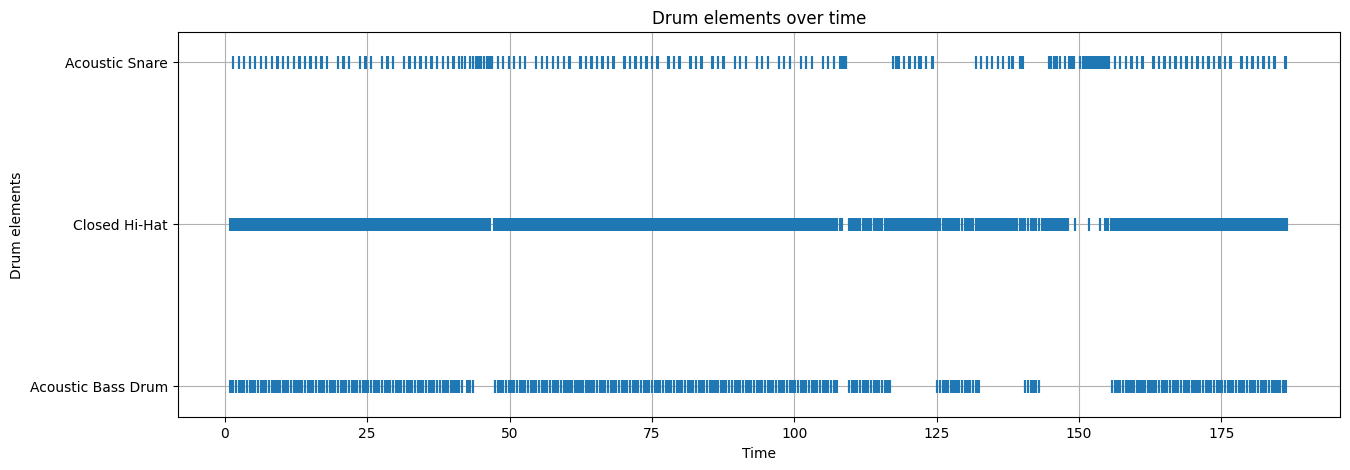

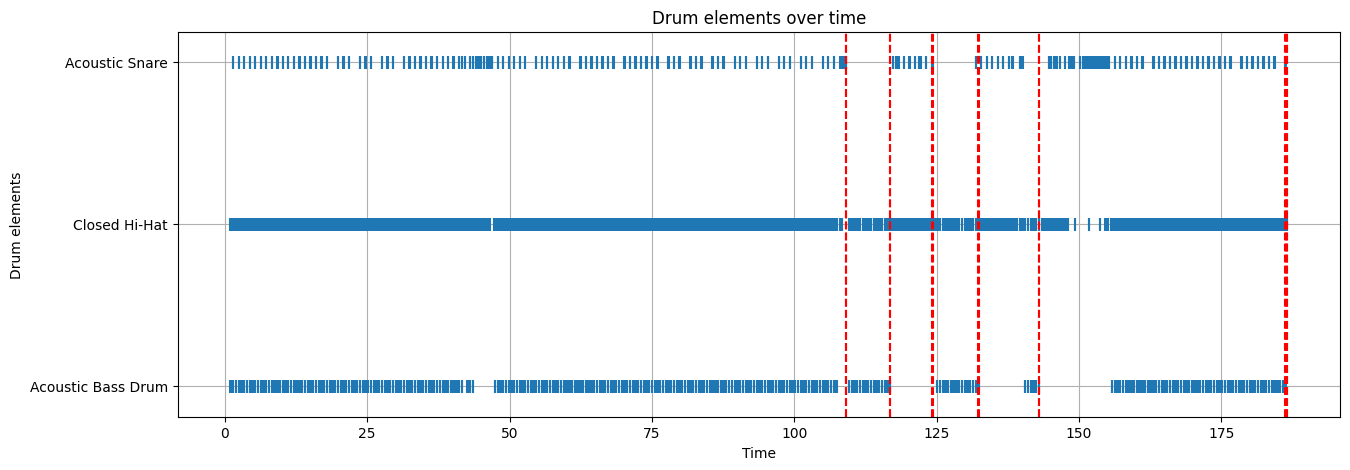

In [71]:
#ドラム要素可視化

in_path = MIDI_INPUT_PATH + 'Nonchalant.mid'
out_path = MIDI_OUTPUT_PATH

visualizer = DrumMidiVisualizer(in_path, out_path)
visualizer.plot()
visualizer.plot_with_pattern_changes()